RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6666 articles,  av length: 321 words,  max length: 4977 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7519 articles,  av length: 84 words,  max length: 594 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропор

### Visualizing articles lengths

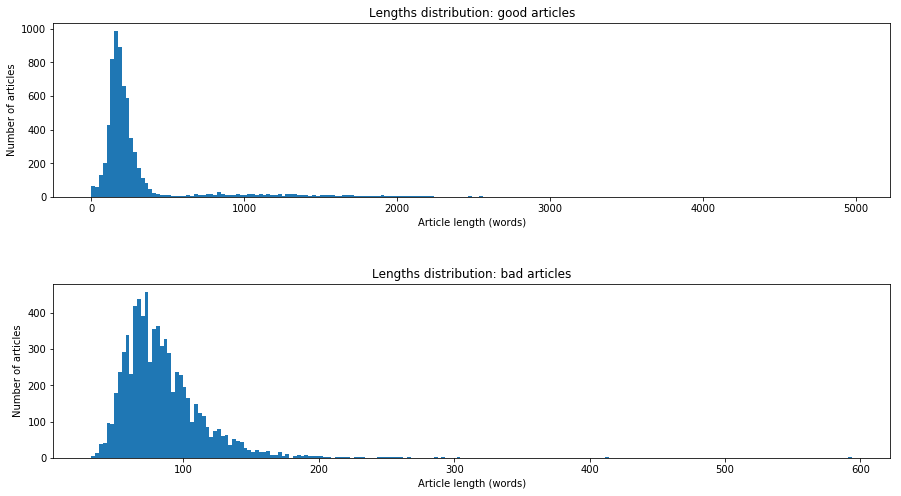

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [4]:
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary, reverse_dictionary, count = build_dictionary(all_words)
good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Top popular words counts: [['UNK', 54385], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59470), ('на', 47402), ('с', 26509), ('что', 22411), ('по', 21900), ('эт', 21548), ('не', 21271), ('из', 16381), ('год', 15883), ('он', 14053)]

Example word: 3144 => слон

Example data: [4, 385, 3, 606, 600, 50, 1918, 1257, 10524, 1302, 540, 1, 89, 359, 255, 2110, 49, 999, 1, 6767]

Validation sizes split train / validation: 6646 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [5]:
batch_size = 20
good = [1, 0] # Representation of first class
bad  = [0, 1] # Representation of second class

batches = BatchIterator(batch_size, good_train_data, bad_train_data, good, bad)

for i in range(20):
  batch = batches.next()
  if i > 17: print(batch)

batches.rewind()

[[3315, 2421, 0, 2, 48, 2536, 3, 2944, 5207, 20, 4, 87, 473, 1, 113, 3, 1098, 14989, 20, 4], [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[87, 2, 347, 1857, 1702, 363, 10311, 1, 105, 254, 11, 6736, 87, 2, 347, 47, 23, 1379, 3, 363], [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


## 2. LSTM Model

In [6]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
num_unrollings = 20 # Number of recurrent steps

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1))
  b = tf.Variable(tf.zeros([num_classes]))
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs         = tf.placeholder(tf.int32, shape=[num_unrollings])
  train_state_cleaners = tf.placeholder(tf.float32, shape=[num_unrollings])
  train_labels         = tf.placeholder(tf.int32, shape=[num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  lstm_inputs = tf.unstack(tf.nn.embedding_lookup(embeddings, train_inputs)) # ~ (num_unrollings, embedding_size)
  lstm_state_cleaners = tf.unstack(train_state_cleaners)

  for lstm_input, state_cleaner in zip(lstm_inputs, lstm_state_cleaners):
    reshaped_lstm_input = tf.reshape(lstm_input, (1, embedding_size))
    output, state = lstm_cell(reshaped_lstm_input,
                              tf.multiply(state_cleaner, output),
                              tf.multiply(state_cleaner, state))
    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(lstm_outputs, 0), w, b) # ~ (num_unrollings, num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    5.0, global_step, 4000, 0.6, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

## 3. Training

In [8]:
def represent(words, predicted_classes):
  label = colored(['=>'], predicted_classes[-1:])[0]
  article = " ".join(colored(words, predicted_classes))

  return f"{label} {article}"

def colored(words, labels):
  colors = []
  for label in labels:
    if abs(label[0] - label[1]) < 0.2: color = 'black'
    elif label[0] > label[1]:          color = 'green'
    else:                              color = 'red'

    colors.append(color)

  return [colored_word(word, color) for word, color in zip(words, colors)]

def colored_word(word, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{word}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

In [10]:
num_steps = 30001
summary_frequency = 100
validation_frequency = 5000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  losses = []
  perpls = []
  for step in range(num_steps):
    batch = batches.next()
    feed_dict = { train_inputs: batch[0],
                  train_labels: batch[1],
                  train_state_cleaners: batch[2] }
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      labels = np.array(batch[1])
      perpl = float(np.exp(logprob(predictions, labels)))
      print(
        'Average loss at step %d: %.4f, perplexity: %.2f, learning rate: %.4f' % (step, mean_loss, perpl, lr))

      losses.append(mean_loss)
      perpls.append(perpl)
      mean_loss = 0

      if step % (summary_frequency * 20) == 0 and step > 3000:
        print('=' * 80)
        for article in validation_data:
          reset_sample_state.run()
          predicted = []
          article_as_words = []
          for word in article:
            article_as_words.append(reverse_dictionary[word])
            prediction = sample_prediction.eval({ sample_input: [word] })
            predicted.append(prediction[0])

          print(represent(article_as_words, predicted))
#           print(" ".join(article_as_words[:5]))
#           print(f'{predicted[-1]} => {}')
        print('=' * 80)

#       if step % (summary_frequency * 10) == 0:
#         # Generate some samples.
#         print('=' * 80)
#         for _ in range(5):
#           feed = sample(random_distribution())
#           sentence = characters(feed)[0]
#           reset_sample_state.run()
#           for _ in range(79):
#             prediction = sample_prediction.eval({sample_input: feed})
#             feed = sample(prediction)
#             sentence += characters(feed)[0]
#           print(sentence)
#         print('=' * 80)
#       # Measure validation set perplexity.
#       reset_sample_state.run()
#       valid_logprob = 0
#       for _ in range(valid_size):
#         b = valid_batches.next()
#         predictions = sample_prediction.eval({sample_input: b[0]})
#         valid_logprob = valid_logprob + logprob(predictions, b[1])
#       print('Validation set perplexity: %.2f' % float(np.exp(
#         valid_logprob / valid_size)))

Initialized
Average loss at step 0: 0.6852, perplexity: 1.98, learning rate: 5.0000
Average loss at step 100: 0.0844, perplexity: 1.00, learning rate: 5.0000
Average loss at step 200: 0.3981, perplexity: 1.01, learning rate: 5.0000
Average loss at step 300: 0.4509, perplexity: 1.01, learning rate: 5.0000
Average loss at step 400: 0.3481, perplexity: 1.00, learning rate: 5.0000
Average loss at step 500: 0.3543, perplexity: 24.98, learning rate: 5.0000
Average loss at step 600: 0.2197, perplexity: 1.02, learning rate: 5.0000
Average loss at step 700: 0.4515, perplexity: 1.00, learning rate: 5.0000
Average loss at step 800: 0.2895, perplexity: 1.01, learning rate: 5.0000
Average loss at step 900: 0.3198, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1000: 0.1330, perplexity: 1.20, learning rate: 5.0000
Average loss at step 1100: 0.3971, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1200: 0.0930, perplexity: 1.00, learning rate: 5.0000
Average loss at step 130

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при эт состоян ещ одн человек оценива как стабильн тяжел . остальн участник дтп наход в удовлетворительн состоян . напомн , авар произошл num сентябр на num километр федеральн автодорог р num амур возл каф меркур . в дтп приня участ грузовик и камаз UNK . в одн из автомобил еха бригад UNK .
=> петербургск аэропорт пулков получ отраслев прем воздушн ворот росс как лучш авиагаван стран . об эт сообща на официальн страниц пулков в . победител был выявл пут многомесячн голосован сред путешественник . отмеча , что пулков был призна лучш сред крупн аэропорт росс с пассажиропоток бол num миллион человек в год . в конц num год пулков уж вход в тройк лучш аэропорт росс по верс , весн тог же год эксперт призна ег одн из лучш в европ . пулков счита одн из сам современ аэропорт росс . ег ежегодн пассажиропоток пре

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 4100: 0.5054, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4200: 0.7064, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4300: 0.2278, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4400: 0.0855, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4500: 0.2884, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4600: 0.3144, perplexity: 108.79, learning rate: 3.0000
Average loss at step 4700: 0.2549, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4800: 0.1592, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4900: 0.2126, perplexity: 1.01, learning rate: 3.0000
Average loss at step 5000: 0.6527, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5100: 0.0408, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5200: 0.3802, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5300: 0.2980, perplexity: 1.00, learning rate: 3.0000
Average loss at step 54

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> москвич четверт ден подряд трав сероводород . в пресс служб UNK сообщ , что четверт ден подряд на восток москв фиксир многократн превышен допустим уровн сероводород в воздух . в частност , в ноч на num сентябр на UNK улиц норм оказа превыш в num раз , а вечер num сентябр в num раз . кром тог , во вторник с num утр до num вечер концентрац сероводород в косин ухтомск превыша допустим показател в num num раз , а в понедельник в num раз . ран сообща , что num сентябр предельн допустим показател на восток москв был превыш в num раз , num сентябр num num раз , num август num num раз , num август num num раз .
=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достиж

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 6100: 0.2168, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6200: 0.0683, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6300: 0.0880, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6400: 0.1522, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6500: 0.2938, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6600: 0.0020, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6700: 0.0475, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6800: 0.4183, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6900: 0.1312, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7000: 0.0621, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7100: 0.0578, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7200: 0.0383, perplexity: 1.30, learning rate: 3.0000
Average loss at step 7300: 0.0361, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7400

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достижен принадлежа японск пилот мич канд и хиразук такезав . он сумел пролетет без посадк на аэростат num час num минут . как рассказа конюх , сам сложн отрезк пут оказа втор ноч , когд из за холод UNK оболочк шар . эт повлия на вес летательн аппарат и , соответствен , увелич расход топлив . днем ран , num феврал , конюх и меняйл поб российск рекорд по продолжительн полет на воздушн шар . он продержа в воздух бол num час .
=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при э

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 8100: 0.1028, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8200: 0.4580, perplexity: 2.96, learning rate: 1.8000
Average loss at step 8300: 0.0364, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8400: 0.0338, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8500: 0.0069, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8600: 0.6037, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8700: 0.3117, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8800: 0.0783, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8900: 0.0434, perplexity: 1.00, learning rate: 1.8000
Average loss at step 9000: 0.5670, perplexity: 1.40, learning rate: 1.8000
Average loss at step 9100: 0.2430, perplexity: 1.00, learning rate: 1.8000
Average loss at step 9200: 0.3464, perplexity: 1.01, learning rate: 1.8000
Average loss at step 9300: 0.1630, perplexity: 1.32, learning rate: 1.8000
Average loss at step 9400

=> герман предлож сша помощ посл удар урага харв по техас . как сообщ официальн представител правительств герман штефф UNK , канцлер фрг ангел меркел направ губернатор американск штат техас , серьезн пострада от удар урага харв , грег UNK предложен по оказан помощ в ликвидац последств стихийн бедств . ангел меркел направ соболезнован населен герман в связ с трагическ последств урага харв и предлож помощ в ликвидац последств урага , котор превзошел урага катрин , обруш num лет назад , сообщ UNK . чита в мк чуд выж в ураган ирм журналистк рассказа о кошмар
=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин 

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> в атлант застрел бенгальск тигриц . в одн из пригород атлант застрел шестилетн бенгальск тигриц сьюз , котор num час гуля по улиц населен пункт и попыта напаст на UNK е собак , переда . тел животн кремирова . в результат расследован выясн , что тигр перевоз из флорид в теннесс , а оттуд хотел направ в герман , чтоб прода в цирк . однак хищник сбежа во врем одн из ночевок . как эт могл произойт , неизвестн .
=> британск совет совместн с сайт запуст мультимедийн проект , посвящен путешеств британск и российск художник , фотограф и музыкант по транссибирск железнодорожн магистра . об эт сообща в пресс релиз проект , поступ в четверг , num феврал , в редакц лент . ру тысяч километр по транссиб проеха UNK эндр диксон , писател алис ганиев и джо UNK , литературн критик и журналист константин UNK , лидер рок групп гриф риз , UNK франческ UNK , фотограф макс UNK и UNK арсен UNK . за врем поездк он побыва в москв , казан , екатеринбург , новосибирск и красноярск , где познаком с местн культу

=> поездк в риг идеальн маршрут на выходн для жител центральн росс . перелет сюд займет мен двух час , а сам экономн путешественник могут отправ в латвийск столиц на поезд билет из москв обойдут в num тысяч рубл . лент . ру рассказыва об обязательн пункт люб визит в риг городск рынк . кажд раз приезж дом в риг , я не упуска возможн пройт по рынк , одн из сам стар и сам больш в европ . ег определен можн назва сам ярк и вкусн достопримечательн столиц пят гектар разнообразн прилавк , начин от UNK мед и заканчив шерстян UNK ручн работ . в городск совет уж в num год активн обсужда необходим постройк центральн рынк , однак перв миров войн отлож решен вопрос до рождеств num год . тогд очен пригод ангар воздушн корабл немецк арм UNK , котор и стал то сам неотъемлем част рижск рынк . имен их большинств путешественник и счита собствен рынк ( на сам дел торговл простира и за предел эт помещен ) . торжествен открыт рынк прошл в num год , а уж через год ег призна сам больш и сам лучш в европ . спус

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 10100: 0.3633, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10200: 0.0630, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10300: 0.2589, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10400: 0.0221, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10500: 0.2377, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10600: 0.0026, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10700: 0.1563, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10800: 0.0781, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10900: 0.0059, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11000: 0.0090, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11100: 0.1688, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11200: 0.0107, perplexity: 1.05, learning rate: 1.8000
Average loss at step 11300: 0.2298, perplexity: 1.40, learning rate: 1.8000
Average loss

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> москвич четверт ден подряд трав сероводород . в пресс служб UNK сообщ , что четверт ден подряд на восток москв фиксир многократн превышен допустим уровн сероводород в воздух . в частност , в ноч на num сентябр на UNK улиц норм оказа превыш в num раз , а вечер num сентябр в num раз . кром тог , во вторник с num утр до num вечер концентрац сероводород в косин ухтомск превыша допустим показател в num num раз , а в понедельник в num раз . ран сообща , что num сентябр предельн допустим показател на восток москв был превыш в num раз , num сентябр num num раз , num август num num раз , num август num num раз .
=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достиж

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 12100: 0.0531, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12200: 0.3927, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12300: 0.1405, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12400: 0.0119, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12500: 0.0299, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12600: 0.0824, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12700: 0.0438, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12800: 0.0625, perplexity: 1.09, learning rate: 1.0800
Average loss at step 12900: 0.0107, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13000: 0.3762, perplexity: 3547.58, learning rate: 1.0800
Average loss at step 13100: 0.2790, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13200: 0.0045, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13300: 0.1989, perplexity: 1.00, learning rate: 1.0800
Average l

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достижен принадлежа японск пилот мич канд и хиразук такезав . он сумел пролетет без посадк на аэростат num час num минут . как рассказа конюх , сам сложн отрезк пут оказа втор ноч , когд из за холод UNK оболочк шар . эт повлия на вес летательн аппарат и , соответствен , увелич расход топлив . днем ран , num феврал , конюх и меняйл поб российск рекорд по продолжительн полет на воздушн шар . он продержа в воздух бол num час .
=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при э

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 14100: 0.0703, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14200: 0.0410, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14300: 0.0165, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14400: 0.2154, perplexity: 3.79, learning rate: 1.0800
Average loss at step 14500: 0.0313, perplexity: 1.21, learning rate: 1.0800
Average loss at step 14600: 0.1541, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14700: 0.0186, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14800: 0.0326, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14900: 0.1492, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15000: 0.2981, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15100: 0.0331, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15200: 0.3560, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15300: 0.0768, perplexity: 1.07, learning rate: 1.0800
Average loss

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> урага ирм разруш почт все строен на остров сен март . как переда со ссылк на местн власт , шест человек погибл из за урага ирм на французск част остров сен март в карибск мор . почт все здан разруш . глав местн совет назва произошедш огромн катастроф . эт огромн катастроф , num остров разруш . я в шок и полн UNK от произошедш , заяв агентств глав местн совет .
=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор 

=> федор конюх соверш нов полет на теплов аэростат через год . об эт заяв сын путешественник оскар , переда в четверг , num феврал , национальн служб новост ( нсн ) . по слов оскар , реч идет о полет в стратосфер для установлен нов миров рекорд по высот подъем на теплов аэростат . действ достижен составля num километр . конюх намер подня до num километр . в настоя врем изготавлива сам больш в мир воздушн шар объем num тысяч кубическ метр . на ег создан уйдет порядк девят месяц , рассказа сын путешественник . имен так размер оболочк позвол подня на высот в num километр , где практическ отсутств кислород , где разрежен воздух . пилот будет наход в специальн капсул . эт уж друг уровен полет , отмет конюх младш . ран в четверг стал известн , что конюх вмест со спортсмен иван меняйл поб миров рекорд по длительн беспосадочн полет на воздушн шар . мужчин смогл провест в неб бол num час . на дан момент врем их полет num час . по информац телекана num , путешественник наход над саратовск област

=> поездк в риг идеальн маршрут на выходн для жител центральн росс . перелет сюд займет мен двух час , а сам экономн путешественник могут отправ в латвийск столиц на поезд билет из москв обойдут в num тысяч рубл . лент . ру рассказыва об обязательн пункт люб визит в риг городск рынк . кажд раз приезж дом в риг , я не упуска возможн пройт по рынк , одн из сам стар и сам больш в европ . ег определен можн назва сам ярк и вкусн достопримечательн столиц пят гектар разнообразн прилавк , начин от UNK мед и заканчив шерстян UNK ручн работ . в городск совет уж в num год активн обсужда необходим постройк центральн рынк , однак перв миров войн отлож решен вопрос до рождеств num год . тогд очен пригод ангар воздушн корабл немецк арм UNK , котор и стал то сам неотъемлем част рижск рынк . имен их большинств путешественник и счита собствен рынк ( на сам дел торговл простира и за предел эт помещен ) . торжествен открыт рынк прошл в num год , а уж через год ег призна сам больш и сам лучш в европ . спус

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 16100: 0.0001, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16200: 0.0176, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16300: 0.2350, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16400: 0.0577, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16500: 0.0957, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16600: 0.0174, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16700: 0.0426, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16800: 0.0046, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16900: 0.0001, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17000: 0.0148, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17100: 0.3794, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17200: 0.1874, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17300: 0.0038, perplexity: 1.00, learning rate: 0.6480
Average loss

=> герман предлож сша помощ посл удар урага харв по техас . как сообщ официальн представител правительств герман штефф UNK , канцлер фрг ангел меркел направ губернатор американск штат техас , серьезн пострада от удар урага харв , грег UNK предложен по оказан помощ в ликвидац последств стихийн бедств . ангел меркел направ соболезнован населен герман в связ с трагическ последств урага харв и предлож помощ в ликвидац последств урага , котор превзошел урага катрин , обруш num лет назад , сообщ UNK . чита в мк чуд выж в ураган ирм журналистк рассказа о кошмар
=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин 

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> федор конюх соверш нов полет на теплов аэростат через год . об эт заяв сын путешественник оскар , переда в четверг , num феврал , национальн служб новост ( нсн ) . по слов оскар , реч идет о полет в стратосфер для установлен нов миров рекорд по высот подъем на теплов аэростат . действ достижен составля num километр . конюх намер подня до num километр . в настоя врем изготавлива сам больш в мир воздушн шар объем num тысяч кубическ метр . на ег создан уйдет порядк девят месяц , рассказа сын путешественник . имен так размер оболочк позвол подня на высот в num километр , где практическ отсутств кислород , где разрежен воздух . пилот будет наход в специальн капсул . эт уж друг уровен полет , отмет конюх младш . ран в четверг стал известн , что конюх вмест со спортсмен иван меняйл поб миров рекорд по длительн беспосадочн полет на воздушн шар . мужчин смогл провест в неб бол num час . на дан момент врем их полет num час . по информац телекана num , путешественник наход над саратовск област

=> поездк в риг идеальн маршрут на выходн для жител центральн росс . перелет сюд займет мен двух час , а сам экономн путешественник могут отправ в латвийск столиц на поезд билет из москв обойдут в num тысяч рубл . лент . ру рассказыва об обязательн пункт люб визит в риг городск рынк . кажд раз приезж дом в риг , я не упуска возможн пройт по рынк , одн из сам стар и сам больш в европ . ег определен можн назва сам ярк и вкусн достопримечательн столиц пят гектар разнообразн прилавк , начин от UNK мед и заканчив шерстян UNK ручн работ . в городск совет уж в num год активн обсужда необходим постройк центральн рынк , однак перв миров войн отлож решен вопрос до рождеств num год . тогд очен пригод ангар воздушн корабл немецк арм UNK , котор и стал то сам неотъемлем част рижск рынк . имен их большинств путешественник и счита собствен рынк ( на сам дел торговл простира и за предел эт помещен ) . торжествен открыт рынк прошл в num год , а уж через год ег призна сам больш и сам лучш в европ . спус

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 18100: 0.0096, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18200: 0.0930, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18300: 0.0037, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18400: 0.0111, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18500: 0.0205, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18600: 0.0013, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18700: 0.0567, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18800: 0.0688, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18900: 0.0181, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19000: 0.4636, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19100: 0.0733, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19200: 0.0518, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19300: 0.0326, perplexity: 1.00, learning rate: 0.6480
Average loss

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достижен принадлежа японск пилот мич канд и хиразук такезав . он сумел пролетет без посадк на аэростат num час num минут . как рассказа конюх , сам сложн отрезк пут оказа втор ноч , когд из за холод UNK оболочк шар . эт повлия на вес летательн аппарат и , соответствен , увелич расход топлив . днем ран , num феврал , конюх и меняйл поб российск рекорд по продолжительн полет на воздушн шар . он продержа в воздух бол num час .
=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при э

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 20100: 0.2375, perplexity: 44.88, learning rate: 0.3888
Average loss at step 20200: 0.0276, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20300: 0.0187, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20400: 0.0213, perplexity: 1.63, learning rate: 0.3888
Average loss at step 20500: 0.0460, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20600: 0.2039, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20700: 0.3193, perplexity: 1.01, learning rate: 0.3888
Average loss at step 20800: 0.1873, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20900: 0.0234, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21000: 0.0047, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21100: 0.0284, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21200: 0.0010, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21300: 0.3342, perplexity: 1.00, learning rate: 0.3888
Average los

=> герман предлож сша помощ посл удар урага харв по техас . как сообщ официальн представител правительств герман штефф UNK , канцлер фрг ангел меркел направ губернатор американск штат техас , серьезн пострада от удар урага харв , грег UNK предложен по оказан помощ в ликвидац последств стихийн бедств . ангел меркел направ соболезнован населен герман в связ с трагическ последств урага харв и предлож помощ в ликвидац последств урага , котор превзошел урага катрин , обруш num лет назад , сообщ UNK . чита в мк чуд выж в ураган ирм журналистк рассказа о кошмар
=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин 

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> урага ирм разруш почт все строен на остров сен март . как переда со ссылк на местн власт , шест человек погибл из за урага ирм на французск част остров сен март в карибск мор . почт все здан разруш . глав местн совет назва произошедш огромн катастроф . эт огромн катастроф , num остров разруш . я в шок и полн UNK от произошедш , заяв агентств глав местн совет .
=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор 

=> num тысяч жител пуэрт рик оста без электроэнерг из за урага ирм . власт пуэрт рик о значительн ущерб , котор причин островн государств урага пят категор ирм . по слов губернатор рикард UNK , без свет оста окол num тысяч человек . уж понятн , что нанес довольн значительн ущерб , сообщ губернатор телеканал .
=> федор конюх соверш нов полет на теплов аэростат через год . об эт заяв сын путешественник оскар , переда в четверг , num феврал , национальн служб новост ( нсн ) . по слов оскар , реч идет о полет в стратосфер для установлен нов миров рекорд по высот подъем на теплов аэростат . действ достижен составля num километр . конюх намер подня до num километр . в настоя врем изготавлива сам больш в мир воздушн шар объем num тысяч кубическ метр . на ег создан уйдет порядк девят месяц , рассказа сын путешественник . имен так размер оболочк позвол подня на высот в num километр , где практическ отсутств кислород , где разрежен воздух . пилот будет наход в специальн капсул . эт уж друг урове

=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при эт состоян ещ одн человек оценива как стабильн тяжел . остальн участник дтп наход в удовлетворительн состоян . напомн , авар произошл num сентябр на num километр федеральн автодорог р num амур возл каф меркур . в дтп приня участ грузовик и камаз UNK . в одн из автомобил еха бригад UNK .
=> петербургск аэропорт пулков получ отраслев прем воздушн ворот росс как лучш авиагаван стран . об эт сообща на официальн страниц пулков в . победител был выявл пут многомесячн голосован сред путешественник . отмеча , что пулков был призна лучш сред крупн аэропорт росс с пассажиропоток бол num миллион человек в год . в конц num год пулков уж вход в тройк лучш аэропорт росс по верс , весн тог же год эксперт призна ег одн из лучш в европ . пулков счита одн из сам современ аэропорт росс . ег ежегодн пассажиропоток пре

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 22100: 0.0112, perplexity: 1.02, learning rate: 0.3888
Average loss at step 22200: 0.0014, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22300: 0.0173, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22400: 0.0232, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22500: 0.0693, perplexity: 1.06, learning rate: 0.3888
Average loss at step 22600: 0.0054, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22700: 0.0134, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22800: 0.1983, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22900: 0.0484, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23000: 0.1337, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23100: 0.0485, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23200: 0.0162, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23300: 0.0034, perplexity: 1.00, learning rate: 0.3888
Average loss

=> москв и симферопол оказа наибол выгодн направлен для перелет по росс в длин выходн в чест num феврал . об эт сообща в пресс релиз турсервис , поступ в лент . ру в сред , num феврал . специалист проанализирова десятк тысяч бронирован авиабилет на аналогичн период в num num год . в итог он спрогнозирова , что цен на перелет в москв и симферопол на num num феврал num год останут примерн на одн уровн вне зависим от времен бронирован . что каса друг направлен по росс и за рубеж , то рад эконом билет лучш покупа заран . к пример , перелет в санкт петербург лучш был бронирова в декабр , так как в феврал средн стоимост путешеств вырастет уж в два раз . аналогичн ситуац складыва с минеральн вод и соч . авиабилет в таиланд на феврал num год в июл num го можн был куп за num тысяч рубл . к феврал цен вырастет до num тысяч . стоимост перелет в итал и герман с num num тысяч рубл в август увелич до num num тысяч . билет в груз в январ сто порядк восьм тысяч рубл . в период февральск выходн , по пр

=> путешеств с домашн питомц всегд лишн хлопот и переживан . сдела ли прививк ? все ли документ подготовл ? все не так страшн . любов UNK уж нескольк лет колес по мир со сво двум кошк . он рассказа лент . ру , как эт сдела . перв и сам главн прав кажд год привива сво животн . эт каса абсолютн всех , даж тех , кто никогд не выпуска питомц дальш порог . путешественник эт ещ и сэконом масс времен и нерв , вед карантин посл прививк от бешенств , в течен котор вам не UNK справк о выезд , составля месяц . при планирован путешеств с кошк ил собак сраз может UNK практическ все островн государств там либ карантин посл прилет , за котор придет плат владельц животн , либ неподъемн кип документ на ввоз . эт каса и некотор UNK государств . например , для поездк в инд нуж объемн пакет документ , в кор не пуст без num дневн карантин , в япон потреб титр на бешенств , а зат опя же отправ в карантин на полгод . перед покупк билет внимательн изуч все прав , каса перевозк животн в самолет . отнюд не все 

=> в атлантическ океан тропическ шторм хос стал ураган . как сообща специалист национальн центр сша по предупрежден ураган , тропическ шторм хос , котор ран сформирова над атлантическ океан , присво статус урага перв категор . скорост ветр в район тропическ шторм хос увелич до num километр в час , что означа , что шторм приобрел признак урага . в настоя врем хос движет в район стран карибск бассейн со скорост num километр в час , сообща эксперт .
=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путеше

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> в атлант застрел бенгальск тигриц . в одн из пригород атлант застрел шестилетн бенгальск тигриц сьюз , котор num час гуля по улиц населен пункт и попыта напаст на UNK е собак , переда . тел животн кремирова . в результат расследован выясн , что тигр перевоз из флорид в теннесс , а оттуд хотел направ в герман , чтоб прода в цирк . однак хищник сбежа во врем одн из ночевок . как эт могл произойт , неизвестн .
=> британск совет совместн с сайт запуст мультимедийн проект , посвящен путешеств британск и российск художник , фотограф и музыкант по транссибирск железнодорожн магистра . об эт сообща в пресс релиз проект , поступ в четверг , num феврал , в редакц лент . ру тысяч километр по транссиб проеха UNK эндр диксон , писател алис ганиев и джо UNK , литературн критик и журналист константин UNK , лидер рок групп гриф риз , UNK франческ UNK , фотограф макс UNK и UNK арсен UNK . за врем поездк он побыва в москв , казан , екатеринбург , новосибирск и красноярск , где познаком с местн культу

=> поездк в риг идеальн маршрут на выходн для жител центральн росс . перелет сюд займет мен двух час , а сам экономн путешественник могут отправ в латвийск столиц на поезд билет из москв обойдут в num тысяч рубл . лент . ру рассказыва об обязательн пункт люб визит в риг городск рынк . кажд раз приезж дом в риг , я не упуска возможн пройт по рынк , одн из сам стар и сам больш в европ . ег определен можн назва сам ярк и вкусн достопримечательн столиц пят гектар разнообразн прилавк , начин от UNK мед и заканчив шерстян UNK ручн работ . в городск совет уж в num год активн обсужда необходим постройк центральн рынк , однак перв миров войн отлож решен вопрос до рождеств num год . тогд очен пригод ангар воздушн корабл немецк арм UNK , котор и стал то сам неотъемлем част рижск рынк . имен их большинств путешественник и счита собствен рынк ( на сам дел торговл простира и за предел эт помещен ) . торжествен открыт рынк прошл в num год , а уж через год ег призна сам больш и сам лучш в европ . спус

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 24100: 0.0132, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24200: 0.4343, perplexity: 1.04, learning rate: 0.2333
Average loss at step 24300: 0.0202, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24400: 0.0775, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24500: 0.1974, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24600: 0.0851, perplexity: 1.05, learning rate: 0.2333
Average loss at step 24700: 0.2524, perplexity: 1.04, learning rate: 0.2333
Average loss at step 24800: 0.2659, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24900: 0.0308, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25000: 0.2458, perplexity: 1.03, learning rate: 0.2333
Average loss at step 25100: 0.0251, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25200: 0.2019, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25300: 0.2179, perplexity: 1.01, learning rate: 0.2333
Average loss

=> герман предлож сша помощ посл удар урага харв по техас . как сообщ официальн представител правительств герман штефф UNK , канцлер фрг ангел меркел направ губернатор американск штат техас , серьезн пострада от удар урага харв , грег UNK предложен по оказан помощ в ликвидац последств стихийн бедств . ангел меркел направ соболезнован населен герман в связ с трагическ последств урага харв и предлож помощ в ликвидац последств урага , котор превзошел урага катрин , обруш num лет назад , сообщ UNK . чита в мк чуд выж в ураган ирм журналистк рассказа о кошмар
=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин 

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> российск воздухоплавател федор конюх и ива меняйл поб миров рекорд по длительн беспосадочн полет на теплов аэростат . об эт корреспондент лент . ру рассказа организатор экспедиц . путешественник провел в неб бол num час . шар пролетел из рыбинск ( ярославск област ) бол тысяч километр , сейчас он наход в район поселк UNK в саратовск област . путешественник продолжа движен в сторон казахста . по слов конюхов сам сложн отрезк пут стал втор ноч . из за холод произошл UNK оболочк шар , что повлия на ег вес и , соответствен , увелич расход топлив . предыдущ миров рекорд принадлежа японск пилот мич канд и хиразук такезав , котор сумел пролетет без посадк num час num минут . воздухоплавател подня в неб на аэростат бинбанк премиум сам больш в росс на дан момент . объ ег оболочк составля num тысяч кубическ метр . утр в сред , num феврал , конюхов и меняйл уда поб рекорд росс по продолжительн полет . он смогл продержа в воздух бол num час . предыдущ рекорд был установл в num год и такж принад

=> британск совет совместн с сайт запуст мультимедийн проект , посвящен путешеств британск и российск художник , фотограф и музыкант по транссибирск железнодорожн магистра . об эт сообща в пресс релиз проект , поступ в четверг , num феврал , в редакц лент . ру тысяч километр по транссиб проеха UNK эндр диксон , писател алис ганиев и джо UNK , литературн критик и журналист константин UNK , лидер рок групп гриф риз , UNK франческ UNK , фотограф макс UNK и UNK арсен UNK . за врем поездк он побыва в москв , казан , екатеринбург , новосибирск и красноярск , где познаком с местн культур и пообща с жител город . итог поездк стал интерактивн сайт UNK , сочета в себ документальн кин , UNK , авторск эсс и репортаж .
=> москвич четверт ден подряд трав сероводород . в пресс служб UNK сообщ , что четверт ден подряд на восток москв фиксир многократн превышен допустим уровн сероводород в воздух . в частност , в ноч на num сентябр на UNK улиц норм оказа превыш в num раз , а вечер num сентябр в num раз

=> поездк в риг идеальн маршрут на выходн для жител центральн росс . перелет сюд займет мен двух час , а сам экономн путешественник могут отправ в латвийск столиц на поезд билет из москв обойдут в num тысяч рубл . лент . ру рассказыва об обязательн пункт люб визит в риг городск рынк . кажд раз приезж дом в риг , я не упуска возможн пройт по рынк , одн из сам стар и сам больш в европ . ег определен можн назва сам ярк и вкусн достопримечательн столиц пят гектар разнообразн прилавк , начин от UNK мед и заканчив шерстян UNK ручн работ . в городск совет уж в num год активн обсужда необходим постройк центральн рынк , однак перв миров войн отлож решен вопрос до рождеств num год . тогд очен пригод ангар воздушн корабл немецк арм UNK , котор и стал то сам неотъемлем част рижск рынк . имен их большинств путешественник и счита собствен рынк ( на сам дел торговл простира и за предел эт помещен ) . торжествен открыт рынк прошл в num год , а уж через год ег призна сам больш и сам лучш в европ . спус

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 26100: 0.0034, perplexity: 1.01, learning rate: 0.2333
Average loss at step 26200: 0.0227, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26300: 0.0276, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26400: 0.0013, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26500: 0.1539, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26600: 0.5248, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26700: 0.0328, perplexity: 1.01, learning rate: 0.2333
Average loss at step 26800: 0.0488, perplexity: 1.01, learning rate: 0.2333
Average loss at step 26900: 0.0007, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27000: 0.0210, perplexity: 1.01, learning rate: 0.2333
Average loss at step 27100: 0.2947, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27200: 0.1880, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27300: 0.2347, perplexity: 1.00, learning rate: 0.2333
Average loss

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> в амстердамск аэропорт UNK тестир нов сист безопасн с распознаван лиц пассажир . проверя паспорт путешественник ил ег посадочн талон при эт не будут . об эт сообща на сайт нидерландск авиакомпан , котор разработа так технолог . перед одн из выход на посадк в воздушн гаван установ специальн регистрацион стойк . пассажир долж будет пройт сканирован лиц , паспорт и посадочн талон . сотрудник окажут помощ в регистрац . все персональн дан будут удаля через деся час . на двер перед выход на посадк установ прибор , котор будет сканирова лиц путешественник и сравнива ег с информац , введен при регистрац . есл сведен не UNK , двер не откроет . тестирован нов систем продл как минимум три месяц . в январ стал известн о план власт австрал ввест подобн сист в сво аэропорт . проверк паспорт зарубежн турист в эт стран реш замен сканирован их лиц , глаз и отпечатк пальц .
=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , вс

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достижен принадлежа японск пилот мич канд и хиразук такезав . он сумел пролетет без посадк на аэростат num час num минут . как рассказа конюх , сам сложн отрезк пут оказа втор ноч , когд из за холод UNK оболочк шар . эт повлия на вес летательн аппарат и , соответствен , увелич расход топлив . днем ран , num феврал , конюх и меняйл поб российск рекорд по продолжительн полет на воздушн шар . он продержа в воздух бол num час .
=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при э

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

Average loss at step 28100: 0.0219, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28200: 0.0342, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28300: 0.0215, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28400: 0.2034, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28500: 0.0354, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28600: 0.0173, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28700: 0.0012, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28800: 0.5297, perplexity: 1.03, learning rate: 0.1400
Average loss at step 28900: 0.0400, perplexity: 1.33, learning rate: 0.1400
Average loss at step 29000: 0.5852, perplexity: 1.84, learning rate: 0.1400
Average loss at step 29100: 0.1302, perplexity: 1.00, learning rate: 0.1400
Average loss at step 29200: 0.1935, perplexity: 1.03, learning rate: 0.1400
Average loss at step 29300: 0.1875, perplexity: 1.01, learning rate: 0.1400
Average loss

=> в феврал наибольш спрос у российск путешественник будет пользова таиланд . об эт корреспондент лент . ру рассказа представител туристическ сервис тут . ру . эксперт компан состав так прогноз на основан предварительн бронирован путевок и поисков запрос отдыха . на втор мест списк из десят позиц оказа вьетн . замыка тройк инд . организова тур по росс попа на четверт строчк рейтинг , по объединен арабск эмират на пят . во втор половин перечн такж вошл доминиканск республик , израил , куб , чех и шри ланк . что каса продаж тур в январ , то зде лидер стал росс , на котор пришл почт трет всех реализова путевок . на втор мест оказа таиланд , на трет вьетн . четверт строчк заня кипр , за ним идет грец . в топ num такж вошл тунис , испан , турц , итал и инд . ран сообща , что наибол востребова у россия направлен отдых в num год стал испан . в тройк лидер такж вошл таиланд и итал .
=> сконча в москв испанск футболист уч в рудн . как сообщ источник , хорош знаком с ситуац , молод человек , ско

=> сотрудник госдепартамент сша эвакуир с баг из за урага ирм . как сообща пресс служб американск внешнеполитическ ведомств , все сотрудник госдеп , находя на багамск остров , будут эвакуирова в связ с приближа ураган num ирм . в связ с ураган ирм num сентябр госдепартамент объяв об эвакуац с багамск остров сотрудник правительств сша , есл их присутств не явля обязательн . такж будут эвакуирова член их сем . . . что каса гражда сша , им рекоменд избега люб поездок на багамск остров , остров теркс и кайкос . а находя там след , есл возможн , покинут эт территор до приход урага , . . . либ найт убежищ в безопасн укрыт , говор в сообщен . чита по тем чуд выж в ураган ирм журналистк рассказа о кошмар
=> в начал феврал самолет авиакомпан соверш сам длин в мир коммерческ рейс из дох ( катар ) в окленд ( нов зеланд ) . специальн для читател лент . ру эксперт туристическ сервис раскр подробн перелет и рассказа о сам продолжительн из существ UNK . кто выполня номер рейс num запущ в феврал num г

=> глав минобрнаук стреля в школ подросток нужда в психологическ помощ . глав минобрнаук ольг васил на пол восточн экономическ форум прокомментирова инцидент в ивантеевск школ . по е мнен , откр стрельб подросток нужда в психологическ помощ , котор ем не оказа ни родител , ни школ . о сво план он писа в соцсет . в связ с эт ольг васильев счита , что инцидент стал повод задума о восстановлен институт школьн психолог . мальчик нужда в помощ . над сер зно задума о возвращен школьн психолог . есл подросток и скажет ком то о проблем , то чащ всег эт будет не совс близк человек , и психолог может стат эт человек , сказа васильев .
=> пожил жительниц штат монта UNK макдоналд ( ) преодолел бол num тысяч километр , передвиг по мир на велосипед . пенсионерк объеха по меньш мер сем стран . об эт сообща телекана . недавн num летн американк побыва в ирланд . путешествова бывш учительниц французск нача в num год , посл выход на пенс . сво перв поездк макдоналд соверш по атлантическ побереж франц . к

=> воздушн шар с путешественник федор конюхов и иван меняйл приземл в район город красн кут в саратовск област . об эт корреспондент лент . ру в четверг , num феврал , рассказа организатор экспедиц . конюх и меняйл провел в воздух в общ сложност бол num час . за эт врем он преодолел num километр . он постав миров рекорд по длительн полет на теплов аэростат . предыдущ аналогичн достижен принадлежа японск пилот мич канд и хиразук такезав . он сумел пролетет без посадк на аэростат num час num минут . как рассказа конюх , сам сложн отрезк пут оказа втор ноч , когд из за холод UNK оболочк шар . эт повлия на вес летательн аппарат и , соответствен , увелич расход топлив . днем ран , num феврал , конюх и меняйл поб российск рекорд по продолжительн полет на воздушн шар . он продержа в воздух бол num час .
=> один из num пострада в дтп в амурск област сконча . в пресс служб правительств амурск област сообщ , что один из участник дтп , в котор пострада num человек , сконча утр num сентябр . при э

=> лиссабон , как и сам португал , бел пятн на туристическ карт путешественник из росс . одн из сам дружелюбн стран европ всем сил стара сохран самобытн в эпох глобализац , чем , собствен говор , и привлека путешественник . корреспондент лент . ру ел бурковск отправ в лиссабон и поня , поч зде хот бы раз в жизн долж побыва кажд . лиссабон один из стар город мир и главн порт португал . расположен близ атлантическ океа город омыва рек UNK . два е берег , на одн из котор располож столиц , а на друг город UNK и UNK , соединя два мост васк да UNK ( сам длин в европ ) и мост num апрел . последн из за сходств конструкц и цвет нередк сравнива с мост золот ворот в сан франциск . перв , что броса в глаз , когд оказыва в город , россып оранжев крыш . оцен их многообраз и наслад панорамн вид можн , подня на знаменит лифт сант UNK . с крыш UNK подъемник , призна в num год памятник национальн значен , открыва панорамн вид на замок свят георг , площад коммерц , рек UNK и близлежа квартал . стоимост п

=> в num е год физик ненадолг показа , что он нашл способ удовлетворительн описан сильн взаимодейств . тогд же возник знаменит бутстрапн подход , через два десятилет приведш к создан нов наук конформн теор пол . сегодн подобн метод применя в теор струн и статистическ физик . популярн об эт написа UNK физик теоретик ната UNK . полвек назад электрослаб сил , объединя электромагнитн и слаб взаимодейств , уж получ хорош описан в рамк тог , что сегодн называ теор UNK вайнберг салам . учен не хвата лиш экспериментальн дан . электрослаб теор типичн теор пол , прощ говор , расширен верс квантов электродинамик , сформулирова к конц num х год ричард UNK , UNK UNK , джулиан UNK , UNK дайсон и друг . учен описа UNK в квантов электродинамик процедур устранен бесконечн . описан взаимодейств начина с формулировк UNK объект , котор в некотор смысл можн поня как сумм UNK и потенциальн част систем квантов пол . в результат UNK теор ферм , созда в num х год и посвящен слаб взаимодейств , оказа UNK верс т

=> экономик не работа на женщин , утвержда автор исследован , международн объединен , специализир на борьб с бедност . средн по мир гендерн разр в зарплат составля num процент . в росс он достига num но не в эт главн повод для огорчен российск представительниц прекрасн пол . социальн виц премьер ольг голодец имен гендерн равноправ называ в числ бесспорн позитивн итог большевистск революц . тем не мен спуст num лет посл тех драматическ событ уж постсоветск росс не может похваста , что в эт вопрос оста вперед планет все . num процент опрошен фонд обществен мнен счита , что российск женщин живет трудн , чем мужчин . а кажд четверт убежд , что у представител сильн пол больш возможн для реализац сво прав . не мен показательн и гендерн структур благосостоян . num процент женщин респондент вци говор об отсутств у них трудов доход . то ест он живут на стипенд , пенс , пособ ил на зарплат супруг , когд реч идет о домохозяйк . тогд как дол мужчин , не имеющ собствен источник заработк , вдво мень

=> пномпен город , в котор относительн немн достопримечательн . главн сокровищ камбодж храмов комплекс ангкор ват наход в восьм час езд от столиц , поэт нередк турист воспринима ег тольк как UNK пункт на эт маршрут . и напрасн в пномпен ест рад чег задержа . и эт не тольк памятник старин врод храм ват UNK , с котор когд то нача город , ил королевск дворц , но и мест , связа с нов истор камбодж , например , школ туол сленг , где красн кхмер за четыр год уб бол num тысяч человек . корреспондент лент . ру ива козл рассказыва , поч туол сленг главн , что нужн увидет в камбодж . num апрел num год радикальн камбоджийск коммунист , известн как красн кхмер , побед в войн с правительствен войск он вошл в столиц стран и буквальн в тот же ден выгна из город бол миллион жител . пол пот счита , что демократическ кампуч ( так государств называ в недолг период ег правлен ) должн быт аграрн стран , и на эт основан счита существован горожа бессмыслен . по ег замысл , жител город должн был обрест смысл 

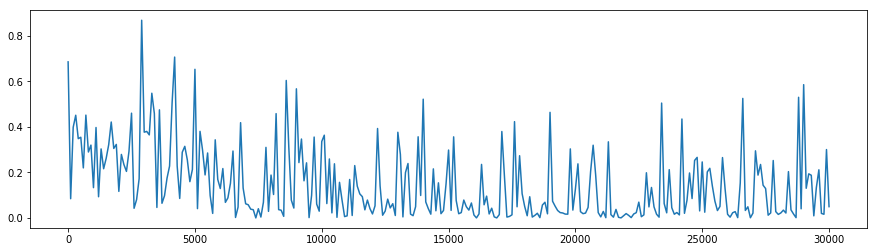

In [11]:
plt.figure().set_size_inches(15, 4)

plt.plot([n * summary_frequency for n in range(0, len(losses))], losses)
plt.show()